In [2]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")

CUDA available: True


In [2]:
# !pip install wandb
# !pip install torch
# !pip install evaluate datasets rouge_score -q

## Import Libraries and Setting Up Environments

In [3]:
# ignore warning
import warnings
warnings.filterwarnings('ignore') 

In [5]:
import transformers
import wandb # weight and biases

import random
import numpy as np
import pandas as pd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.figure_factory as ff
from scipy import stats

from sklearn.feature_extraction.text import TfidfVectorizer # tf-idf
import nltk
from nltk.corpus import stopwords 

import re # clean text data

# Huggingface
from evaluate import load
from datasets import Dataset, DatasetDict
from huggingface_hub import notebook_login
from transformers import AutoTokenizer
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer, pipeline # model

In [6]:
# log in huggingface
notebook_login()

* ### setting up Weights & Biases (wandb)

In [7]:
user_secrets = UserSecretsClient()
my_secret = user_secrets.get_secret("wandb_api_key") 
wandb.login(key=my_secret)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

* ### adjust visualization color

In [7]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (17,7)
plt.rcParams['font.size'] = 14

## Load a Datasets

In [8]:
train_df = pd.read_csv("datasets/samsum-train.csv")
test_df = pd.read_csv("datasets/samsum-test.csv")
val_df = pd.read_csv("datasets/samsum-validation.csv")

## Exploratory Data Analysis (EDA)

Analyst the train, test, and validation datasets.

In [9]:
# function for displays the features within each list for each type of data
def display_feature_list(features, feature_type):
    print(f"\n{feature_type} Features: ")
    print(', '.join(features) if features else 'None')

# function for prints some basic info on the dataset and sets global variables for feature lists.
def describe_df(df):
    global categorical_features, continuous_features, binary_features
    categorical_features = [col for col in df.columns if df[col].dtype == 'object']
    binary_features = [col for col in df.columns if df[col].nunique() <= 2 and df[col].dtype != 'object']
    continuous_features = [col for col in df.columns if df[col].dtype != 'object' and col not in binary_features]

    print(f"\n{type(df).__name__} shape: {df.shape}")
    print('-'*20)
    print(f"\n{df.shape[0]:,.0f} samples")
    print('-'*20)
    print(f"\n{df.shape[1]:,.0f} attributes")
    print('-'*20)
    print(f'\nMissing Data: \n{df.isnull().sum()}')
    print('-'*20)
    print(f'\nDuplicates: {df.duplicated().sum()}')
    print('-'*20)
    print(f'\nData Types: \n{df.dtypes}')
    print('-'*20)
    #negative_valued_features = [col for col in df.columns if (df[col] < 0).any()]
    #print(f'\nFeatures with Negative Values: {", ".join(negative_valued_features) if negative_valued_features else "None"}')

    display_feature_list(categorical_features, 'Categorical')
    print('-'*20)
    display_feature_list(continuous_features, 'Continuous')
    print('-'*20)
    display_feature_list(binary_features, 'Binary')
    print('-'*20)
    
    print(f'\n{type(df).__name__} Head: \n')
    display(df.head(5))
    print(f'\n{type(df).__name__} Tail: \n')
    display(df.tail(5))

In [10]:
def create_eda_df(df):
    eda_df = pd.DataFrame()
    
    eda_df = df.drop(['id'], axis=1)
    eda_df['dialogue_length'] = df['dialogue'].str.len()
    eda_df['summary_length'] = df['summary'].str.len()
    eda_df['dialogue_word_count'] = df['dialogue'].apply(lambda x: len(x.split()))
    eda_df['summary_word_count'] = df['summary'].apply(lambda x: len(x.split()))
    
    return eda_df

### Train Datasets

In [11]:
describe_df(train_df)


DataFrame shape: (14732, 3)
--------------------

14,732 samples
--------------------

3 attributes
--------------------

Missing Data: 
id          0
dialogue    1
summary     0
dtype: int64
--------------------

Duplicates: 0
--------------------

Data Types: 
id          object
dialogue    object
summary     object
dtype: object
--------------------

Categorical Features: 
id, dialogue, summary
--------------------

Continuous Features: 
None
--------------------

Binary Features: 
None
--------------------

DataFrame Head: 



id                                           dialogue  \
0  13818513  Amanda: I baked  cookies. Do you want some?\r\...   
1  13728867  Olivia: Who are you voting for in this electio...   
2  13681000  Tim: Hi, what's up?\r\nKim: Bad mood tbh, I wa...   
3  13730747  Edward: Rachel, I think I'm in ove with Bella....   
4  13728094  Sam: hey  overheard rick say something\r\nSam:...   

                                             summary  
0  Amanda baked cookies and will bring Jerry some...  
1  Olivia and Olivier are voting for liberals in ...  
2  Kim may try the pomodoro technique recommended...  
3  Edward thinks he is in love with Bella. Rachel...  
4  Sam is confused, because he overheard Rick com...


DataFrame Tail: 



id                                           dialogue  \
14727  13863028  Romeo: You are on my ‘People you may know’ lis...   
14728  13828570  Theresa: <file_photo>\r\nTheresa: <file_photo>...   
14729  13819050  John: Every day some bad news. Japan will hunt...   
14730  13828395  Jennifer: Dear Celia! How are you doing?\r\nJe...   
14731  13729017  Georgia: are you ready for hotel hunting? We n...   

                                                 summary  
14727  Romeo is trying to get Greta to add him to her...  
14728  Theresa is at work. She gets free food and fre...  
14729  Japan is going to hunt whales again. Island an...  
14730  Celia couldn't make it to the afternoon with t...  
14731  Georgia and Juliette are looking for a hotel i...

From summarized trained datasets, we observed that we have 14,732 pairs of dialogues and summaries and 
we also known there is 1 missing data in dialogue, so we remove from the dataset.

In [12]:
# remove missing value in train dataset
train_df = train_df.dropna()

In [13]:
# check missing data again
train_df.isnull().sum()

id          0
dialogue    0
summary     0
dtype: int64

* #### Create dataset that have length and count the word of dialogue and summary

In [14]:
eda_train_df = create_eda_df(train_df)

In [15]:
eda_train_df.head()

dialogue  \
0  Amanda: I baked  cookies. Do you want some?\r\...   
1  Olivia: Who are you voting for in this electio...   
2  Tim: Hi, what's up?\r\nKim: Bad mood tbh, I wa...   
3  Edward: Rachel, I think I'm in ove with Bella....   
4  Sam: hey  overheard rick say something\r\nSam:...   

                                             summary  dialogue_length  \
0  Amanda baked cookies and will bring Jerry some...               94   
1  Olivia and Olivier are voting for liberals in ...              111   
2  Kim may try the pomodoro technique recommended...              528   
3  Edward thinks he is in love with Bella. Rachel...              155   
4  Sam is confused, because he overheard Rick com...              909   

   summary_length  dialogue_word_count  summary_word_count  
0              56                   16                   9  
1              61                   18                  10  
2              77                   98                  14  
3              97                   26                  18  
4             145                  179                  27

* #### Visualize the Boxplot-Histogram

In [16]:
def visualize(data, col):
    fig = make_subplots(
        rows=1,
        cols=2,
        subplot_titles=["Box Plot", "Density Plot"],
        horizontal_spacing=0.2
    )

    # Box plot
    fig.add_trace(go.Box(y=data[col], name="Box Plot", boxmean=True, line=dict(color='red')), row=1, col=1)

    # Density plot
    density = stats.gaussian_kde(data[col])
    x_vals = np.linspace(min(data[col]), max(data[col]), 200)
    density_vals = density(x_vals)
    fig.add_trace(go.Scatter(x=x_vals, y=density_vals, mode='lines', fill='tozeroy', name="Density", line=dict(color='blue')), row=1, col=2)

    fig.update_layout(title={'text': f'<b>{col} Distribution</b>', 'x': 0.5, 'xanchor': 'center'},
                      height=500, width=1000)
    fig.update_yaxes(title_text=f"<b>{col}</b>", row=1, col=1)
    fig.update_yaxes(title_text="<b>Density</b>", row=1, col=2)
    fig.update_xaxes(title_text="<b>Value</b>", row=1, col=2)

    fig.show()

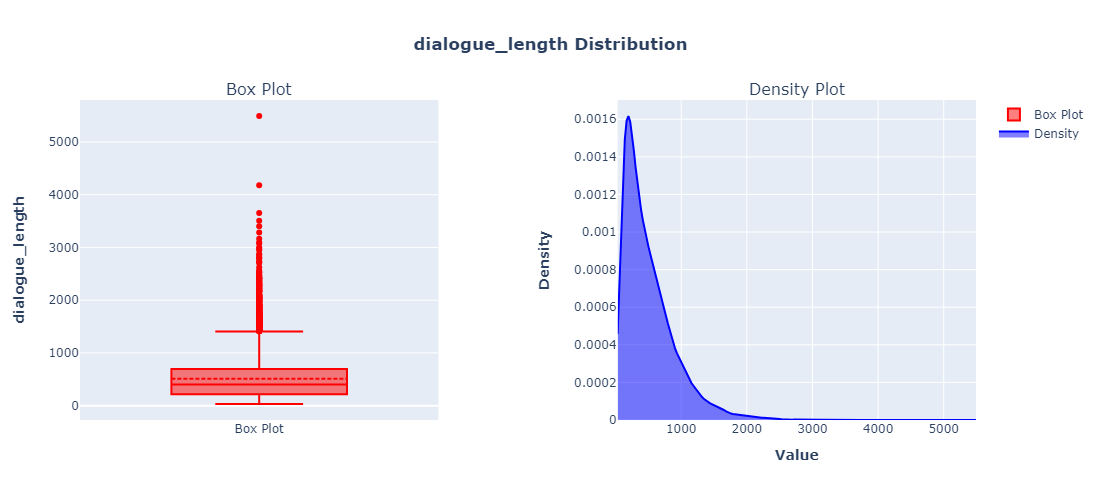

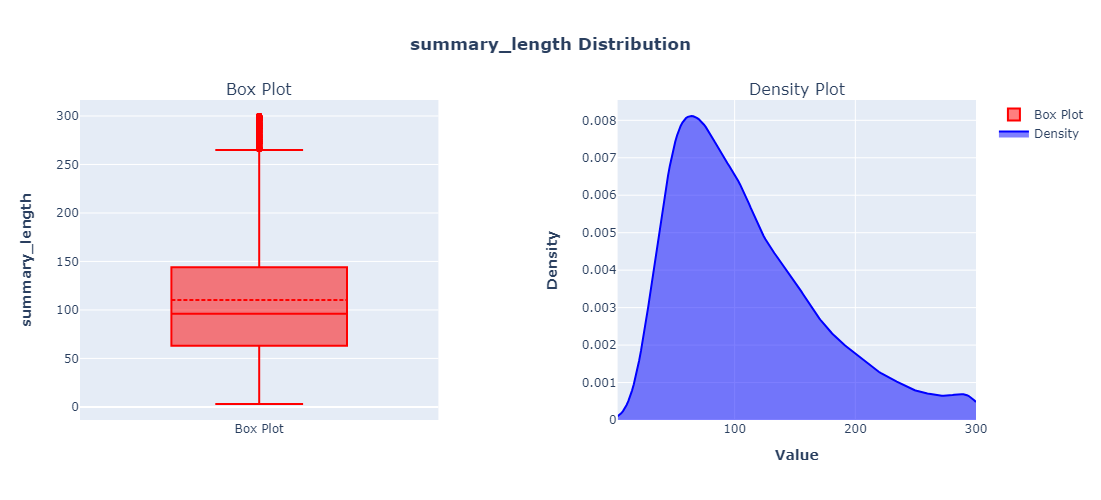

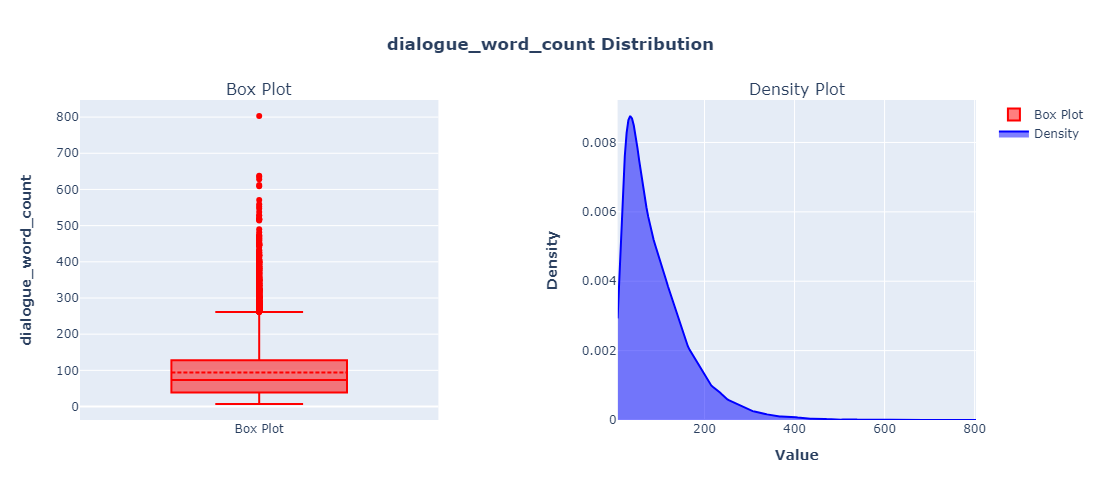

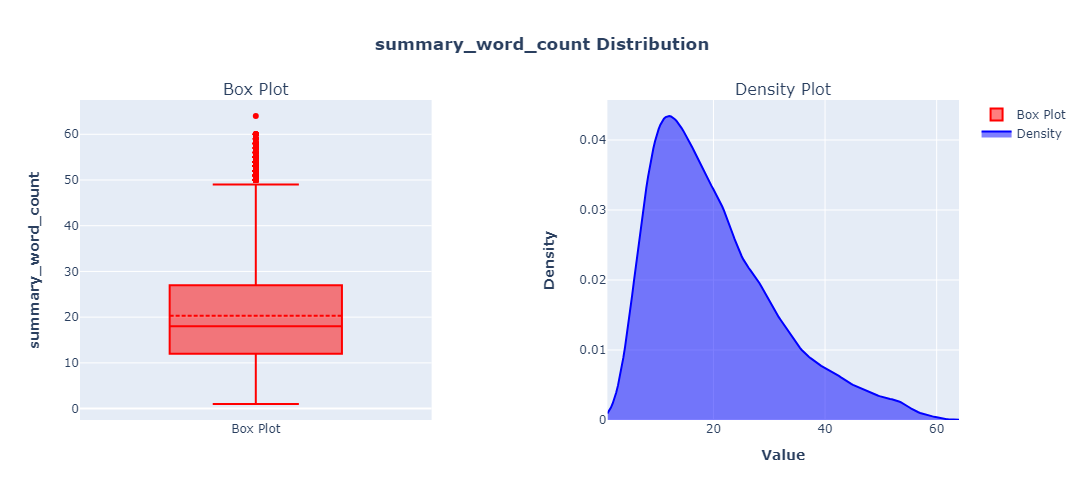

In [17]:
cols = eda_train_df.columns[2:]
for col in cols:
    visualize(eda_train_df, col)

From this boxplot-histogram visualization of train datasets, we observed that
- **Dialogue Word Count**
    - The average word count(mean) of the dialogue is around 94 words
    - There are several dialogue(outliers) above 261 words
    - From histogram plot(right side), show a right-skewed distribution. Most summaries are short, with a high frequency of around 35 words.
- **Summary Word Count**
    - The average word count(mean) of the summarize is around 20 words
    - There are several dialogue(outliers) above 49 words
    - From histogram plot(right side), show a right-skewed distribution. Most summaries are short, with a high frequency of around 12 words.

* #### TF-IDF
    * We use scikit-learn's **TfidfVectorizer** to extract more info on the dialogues and summaries available. This function will transforms text data into a matrix of TF-IDF scores and also give us a dataframe with the top n most frequent terms in the corpus, which we select by using the **max_features** parameter.

    * We will also use the ngram_range parameter to select the most frequent words **(unigrams)**, the most frequent sequence of two words **(bigrams)**, and the most frequent sequence of three words **(trigrams)**.

    * After measuring the most frequent terms, I will plot a heatmap displaying the correlations between these terms. This may help us understand how frequently they are used together in dialogues. 

In [18]:
# for plotting a correlation map among features in the dataset.

def plot_correlation(df, title, subtitle, height, width, font_size):
    '''
    Parameters:
    height = Define height
    width = Define width
    font_size = Define the font size for the annotations
    '''
    corr = np.round(df.corr(numeric_only=True), 2)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    c_mask = np.where(~mask, corr, 100)

    c = []
    for i in c_mask.tolist()[1:]:
        c.append([x for x in i if x != 100])

    fig = ff.create_annotated_heatmap(z=c[::-1],
                                      x=corr.index.tolist()[:-1],
                                      y=corr.columns.tolist()[1:][::-1],
                                      colorscale='Viridis')

    fig.update_layout(title={'text': f"<b>{title} Heatmap<br><sup>&nbsp;&nbsp;&nbsp;&nbsp;<i>{subtitle}</i></sup></b>",
                             'x': .025, 'xanchor': 'left', 'y': .95},
                      margin=dict(t=210, l=110),
                      yaxis=dict(autorange='reversed', showgrid=False),
                      xaxis=dict(showgrid=False),
                      height=height, width=width)

    fig.add_trace(go.Heatmap(z=c[::-1],
                             colorscale='Viridis',
                             showscale=True,
                             visible=False))
    fig.data[1].visible = True

    for i in range(len(fig.layout.annotations)):
        fig.layout.annotations[i].font.size = font_size

    fig.show()

* #### Unigrams

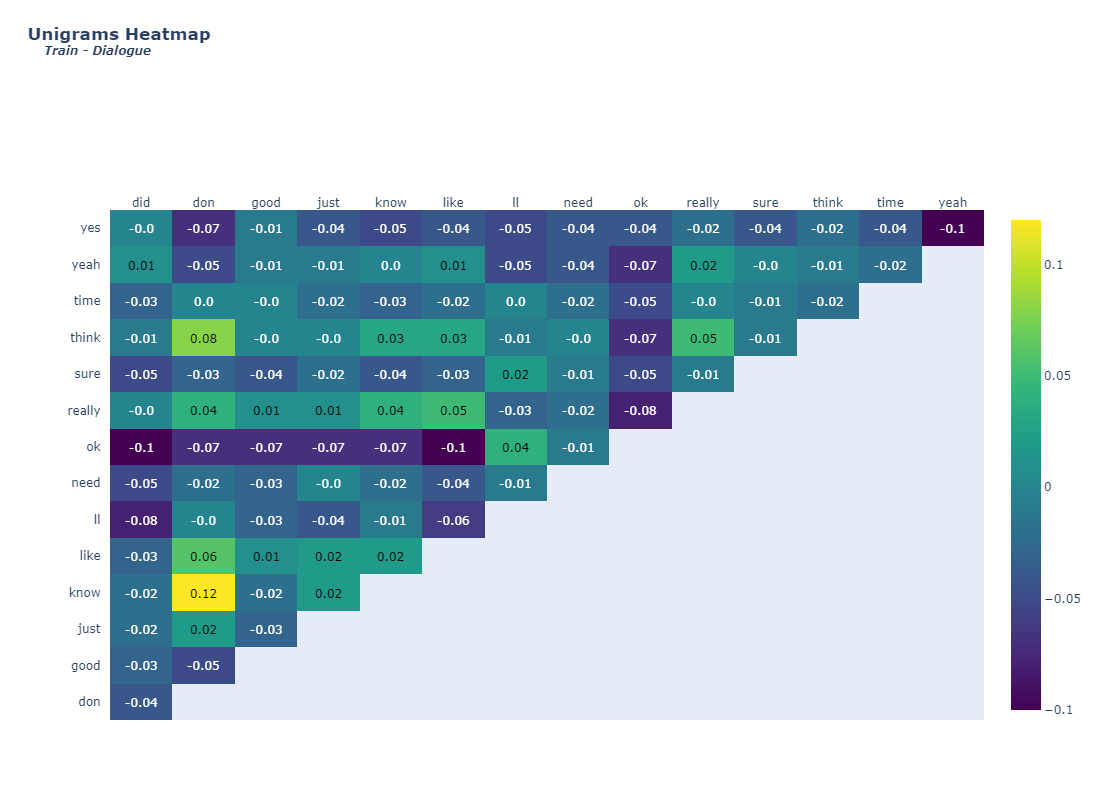

In [19]:
# Unigram Dialogue Heatmap
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english') # Top 15 terms
x = vectorizer.fit_transform(train_df['dialogue'])
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Unigrams', 'Train - Dialogue', 800, 800, 12)

From this unigram dialogue heatmap, we observed that
- The most positively correlated terms are "don" and "know", at 0.12
- The most negative correlation (not extremely significant) between the terms "yes" and "yeah"
    - maybe this happens because it would be redundant to include both in the same dialogue, or perhaps the data captures a tendency of individuals to use "yeah" instead of "yes" during conversations. 

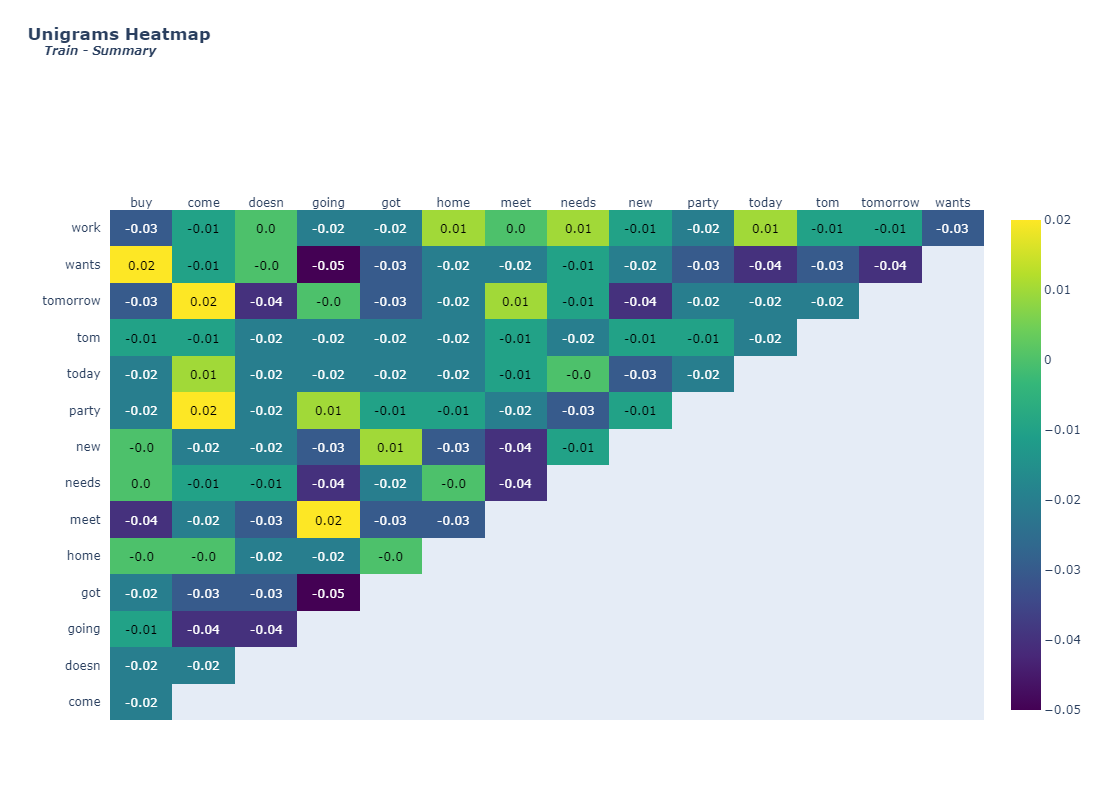

In [20]:
# Unigram Summary Heatmap
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english') # Top 15 terms
x = vectorizer.fit_transform(train_df['summary'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Unigrams', 'Train - Summary', 800, 800, 12)

From this unigram summary heatmap, we observed that
- This suggests that summaries may convey relevant information more clearly than full dialogues, have positively correlated pairs such as **"going" and "meet"**, **"come" and "party"**, as well as **"buy" and "wants"**. It makes perfect sense to see these unigrams appearing together across texts.
- It's reasonable for negatively correlated pairs not to co-occur frequently in texts, such as **"going" and "wants"**, and **"going" and "got"**.

* #### Bigrams

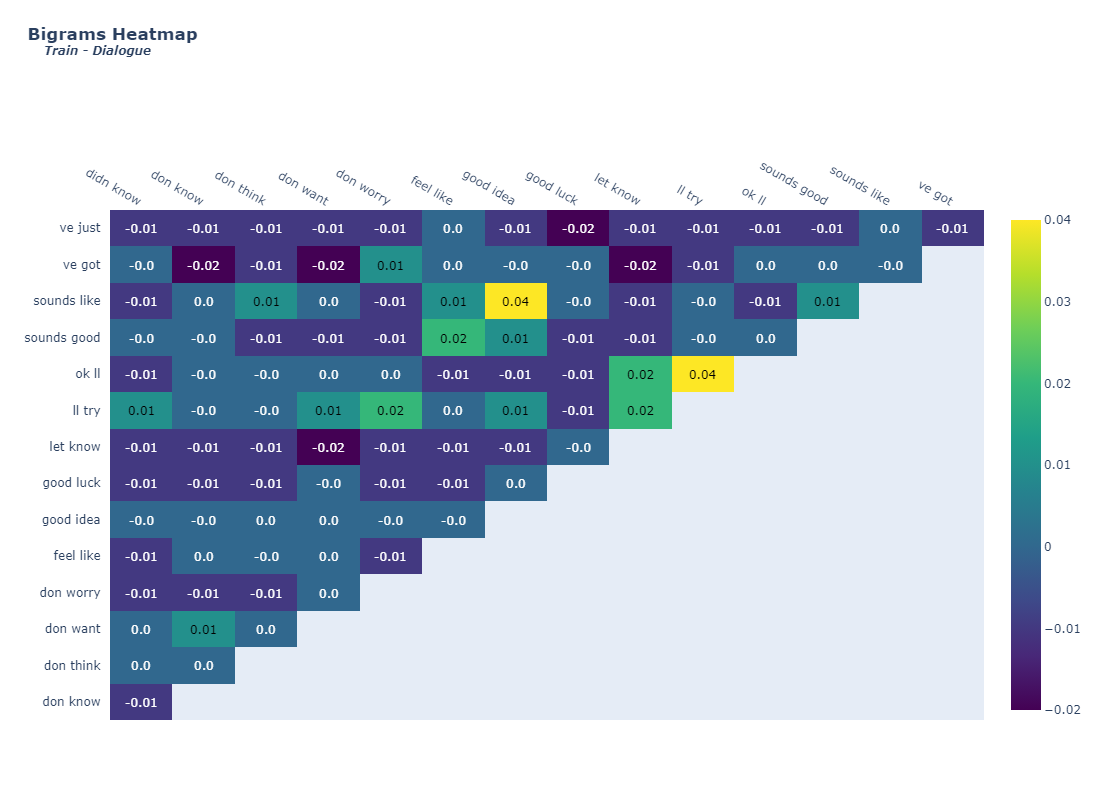

In [21]:
# Bigram Dialogue Heatmap
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (2,2)) # Top 15 terms
x = vectorizer.fit_transform(train_df['dialogue'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Bigrams', 'Train - Dialogue', 800, 800, 12)

From the visualization, we observed that the correlations are not quite strong. But we can see some pairs that seem reasonable **"good idea" and "sounds like"**, **"ok II" and "II try"**

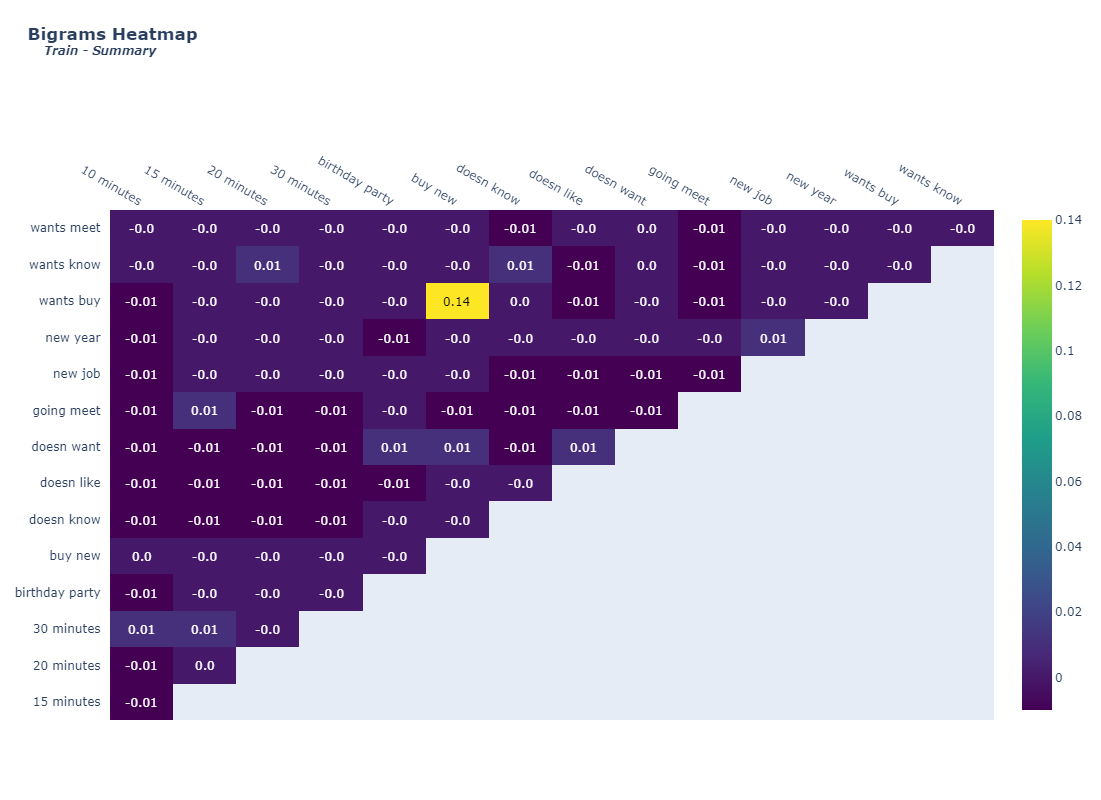

In [22]:
# Bigram Summary Heatmap
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (2,2)) # Top 15 terms
x = vectorizer.fit_transform(train_df['summary'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Bigrams', 'Train - Summary', 800, 800, 12)

From above heatmap, We have only one correlation between the pairs **"wants buy" and "buy new"**. The rest don't have any kind of correlation at all.**

* #### Trigrams

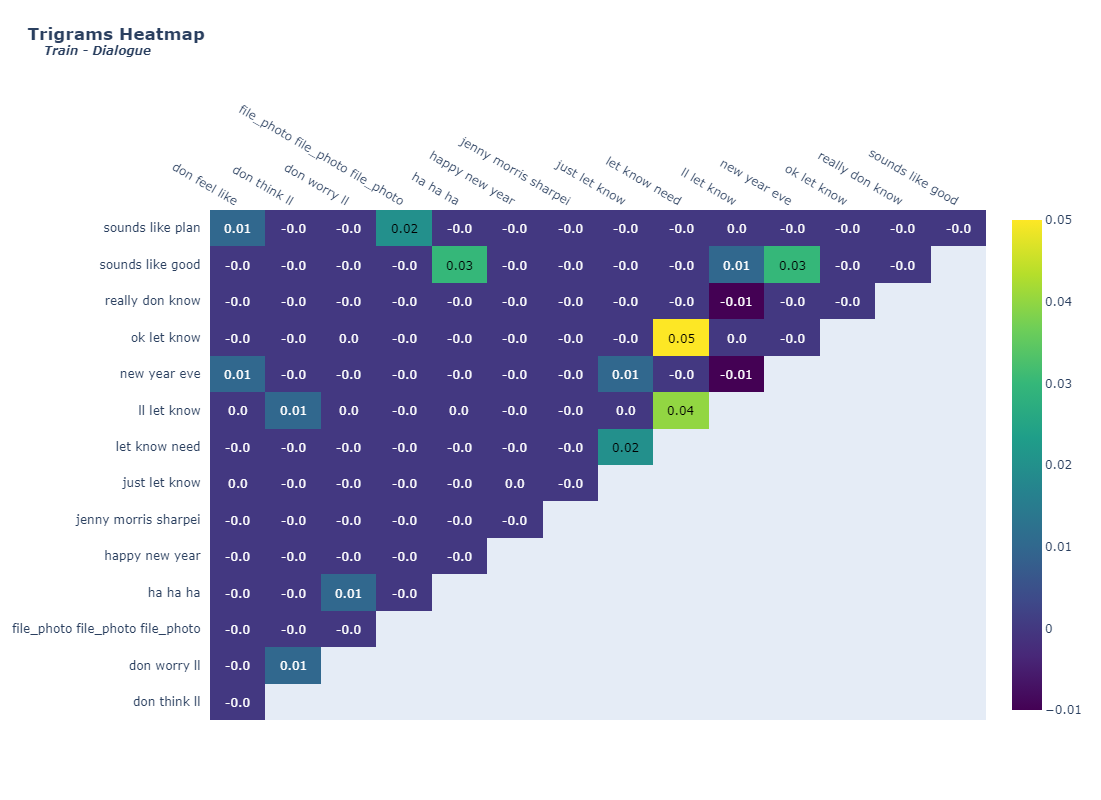

In [23]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (3,3)) # Top 15 terms
x = vectorizer.fit_transform(train_df['dialogue'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Trigrams', 'Train - Dialogue', 800, 800, 12)

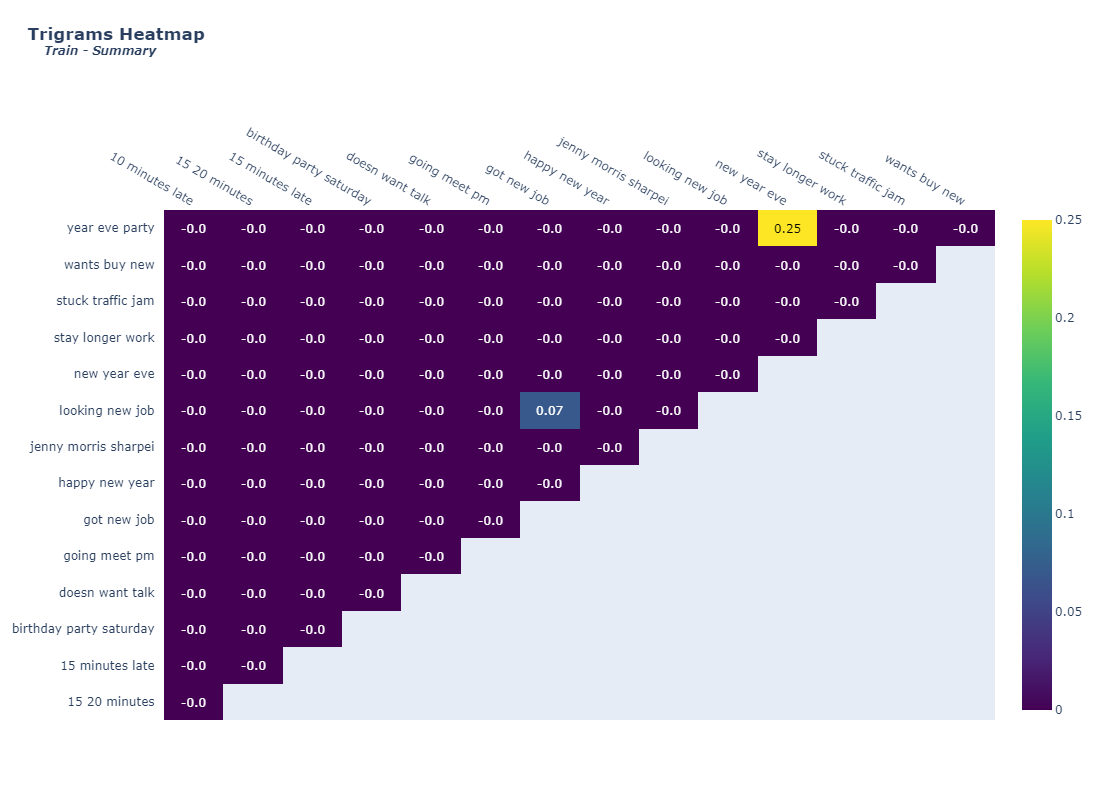

In [24]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (3,3)) # Top 15 terms
x = vectorizer.fit_transform(train_df['summary'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Trigrams', 'Train - Summary', 800, 800, 12)

We can see that the terms are not strongly correlated. But still, it is possible to see pairs that seem logical to appear together in the corpus.

#### Test Dataset

In [25]:
describe_df(test_df)


DataFrame shape: (819, 3)
--------------------

819 samples
--------------------

3 attributes
--------------------

Missing Data: 
id          0
dialogue    0
summary     0
dtype: int64
--------------------

Duplicates: 0
--------------------

Data Types: 
id          object
dialogue    object
summary     object
dtype: object
--------------------

Categorical Features: 
id, dialogue, summary
--------------------

Continuous Features: 
None
--------------------

Binary Features: 
None
--------------------

DataFrame Head: 



id                                           dialogue  \
0  13862856  Hannah: Hey, do you have Betty's number?\nAman...   
1  13729565  Eric: MACHINE!\r\nRob: That's so gr8!\r\nEric:...   
2  13680171  Lenny: Babe, can you help me with something?\r...   
3  13729438  Will: hey babe, what do you want for dinner to...   
4  13828600  Ollie: Hi , are you in Warsaw\r\nJane: yes, ju...   

                                             summary  
0  Hannah needs Betty's number but Amanda doesn't...  
1  Eric and Rob are going to watch a stand-up on ...  
2  Lenny can't decide which trousers to buy. Bob ...  
3  Emma will be home soon and she will let Will k...  
4  Jane is in Warsaw. Ollie and Jane has a party....


DataFrame Tail: 



id                                           dialogue  \
814  13611902-1  Alex: Were you able to attend Friday night's b...   
815    13820989  Jamilla: remember that the audition starts at ...   
816    13717193  Marta: <file_gif>\r\nMarta: Sorry girls, I cli...   
817    13829115  Cora: Have you heard how much fuss British med...   
818    13818810  Rachel: <file_other>\r\nRachel: Top 50 Best Fi...   

                                               summary  
814  Benjamin didn't come to see a basketball game ...  
815      The audition starts at 7.30 P.M. in Antena 3.  
816                    Marta sent a file accidentally,  
817  There was a meet-and-greet with James Charles ...  
818  Rachel sends a list of Top 50 films of 2018. J...

* #### Visualize the Boxplot-Histogram on Test Dataset

In [26]:
eda_test_df = create_eda_df(test_df)

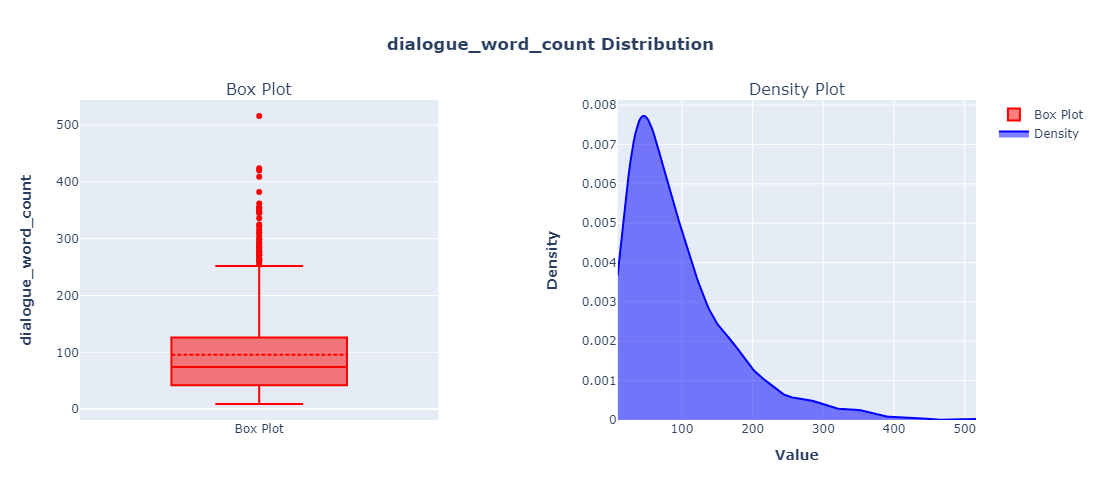

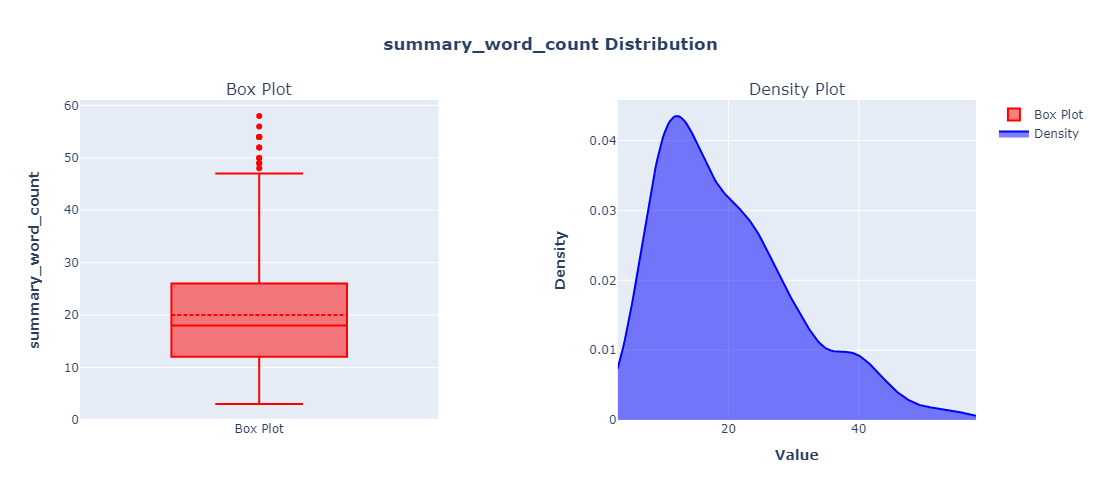

In [27]:
cols = eda_test_df.columns[4:]
for col in cols:
    visualize(eda_test_df, col)

From this boxplot-histogram visualization of test dataset, we observed that
- **Dialogue Word Count**
    - The average word count(mean) of the dialogue is around 96 words
    - There are several dialogue(outliers) above 252 words
    - From histogram plot(right side), show a right-skewed distribution. Most summaries are short, with a high frequency of around 44 words.
- **Summary Word Count**
    - The average word count(mean) of the summarize is around 20 words
    - There are several dialogue(outliers) above 47 words
    - From histogram plot(right side), show a right-skewed distribution. Most summaries are short, with a high frequency of around 12 words.

* #### Analyze Unigram,Bigram and trigram in Test Dataset

- Unigram

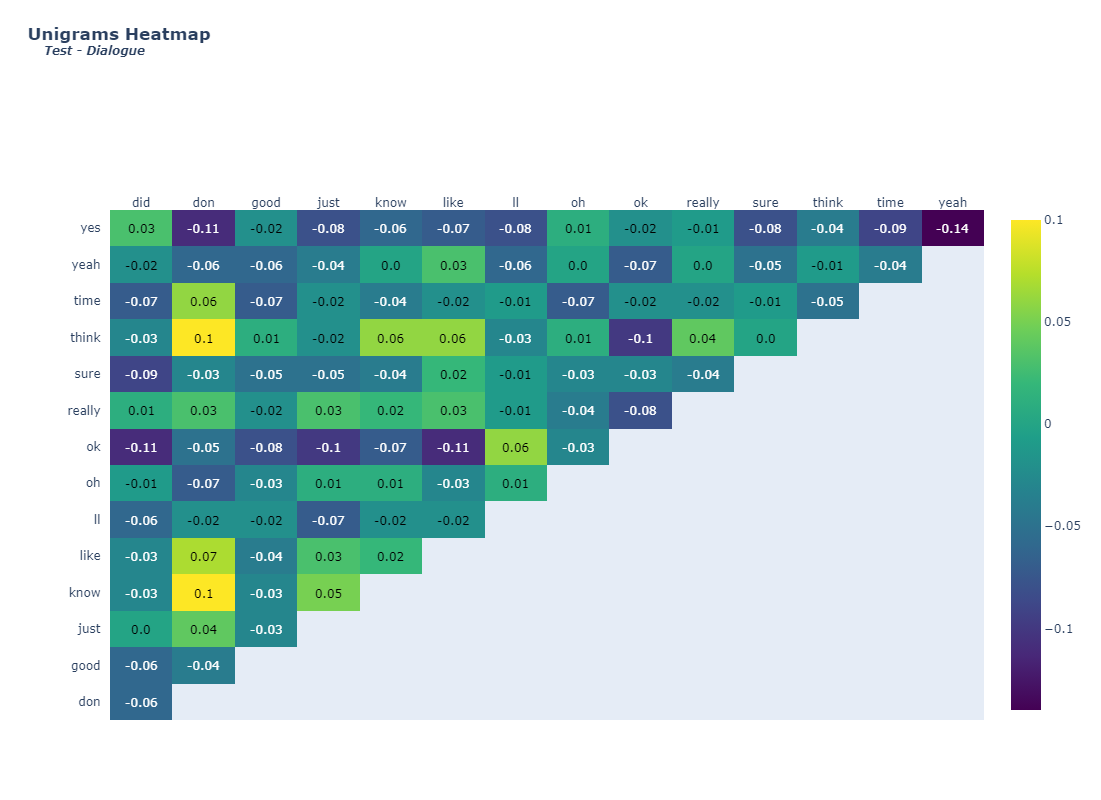

In [28]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english') # Top 15 terms
x = vectorizer.fit_transform(test_df['dialogue'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Unigrams', 'Test - Dialogue', 800, 800, 12)

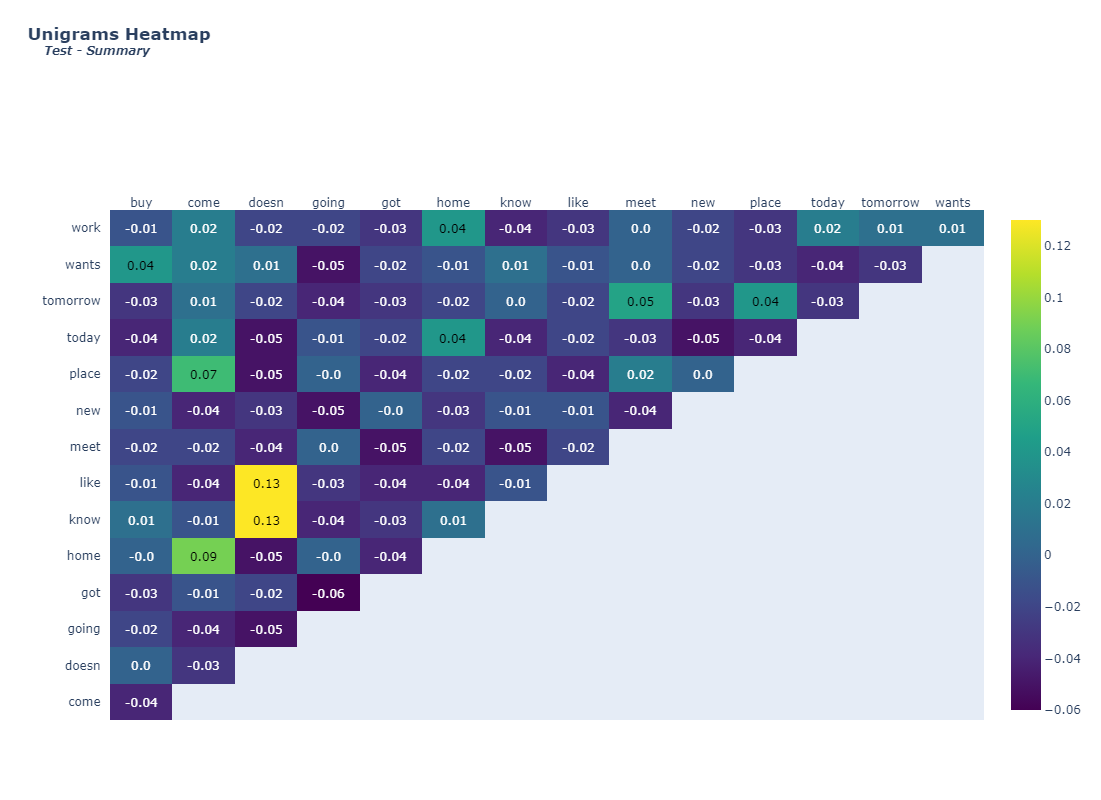

In [29]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english') # Top 15 terms
x = vectorizer.fit_transform(test_df['summary'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Unigrams', 'Test - Summary', 800, 800, 12)

- Bigram

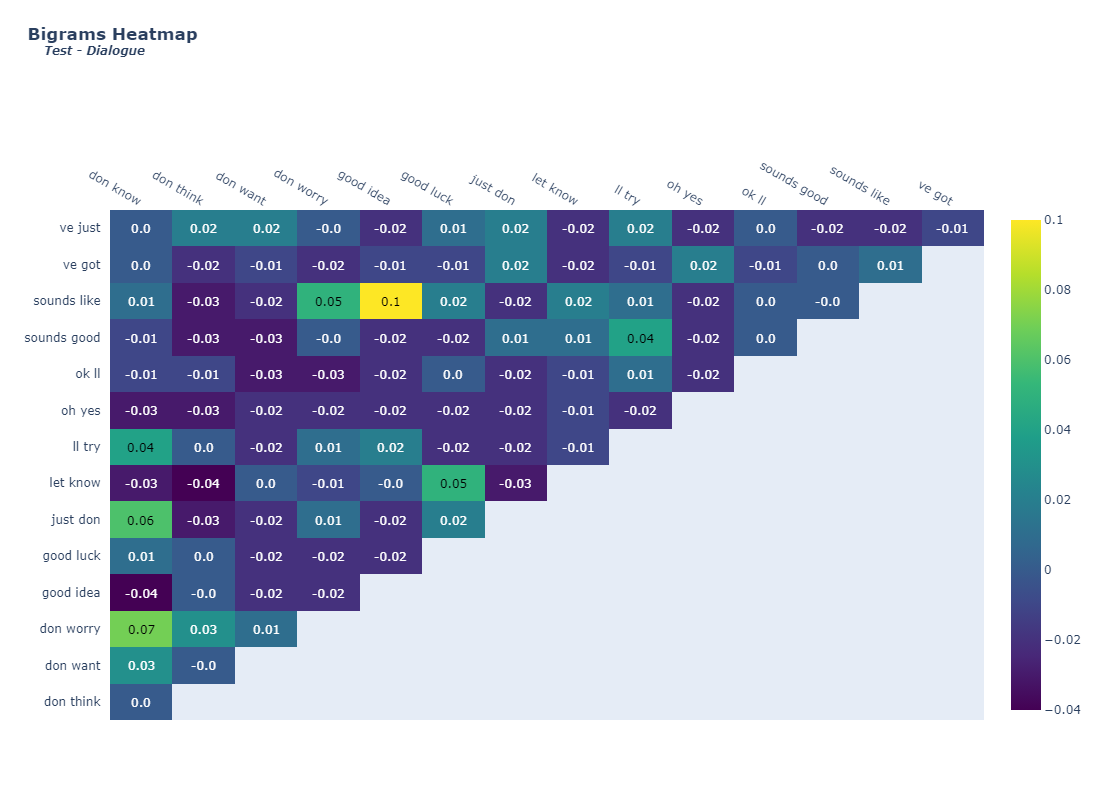

In [30]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (2,2)) # Top 15 terms
x = vectorizer.fit_transform(test_df['dialogue'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Bigrams', 'Test - Dialogue', 800, 800, 12)

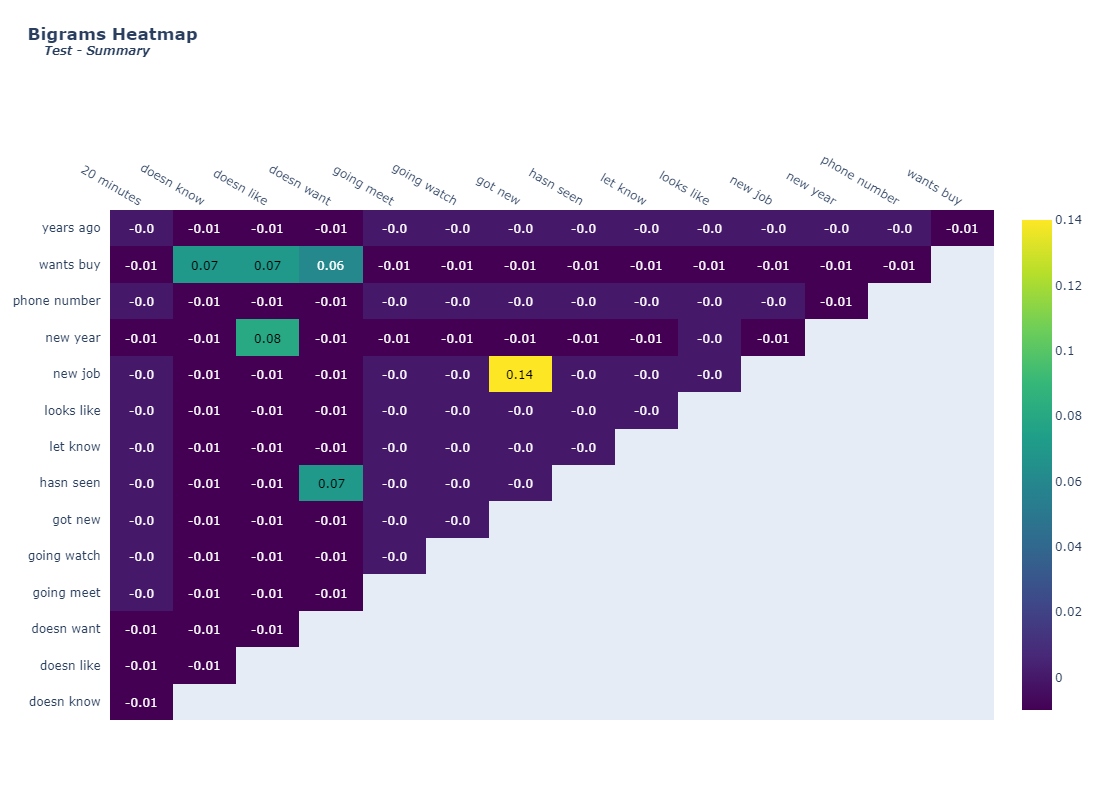

In [31]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (2,2)) # Top 15 terms
x = vectorizer.fit_transform(test_df['summary'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Bigrams', 'Test - Summary', 800, 800, 12)

- Trigram

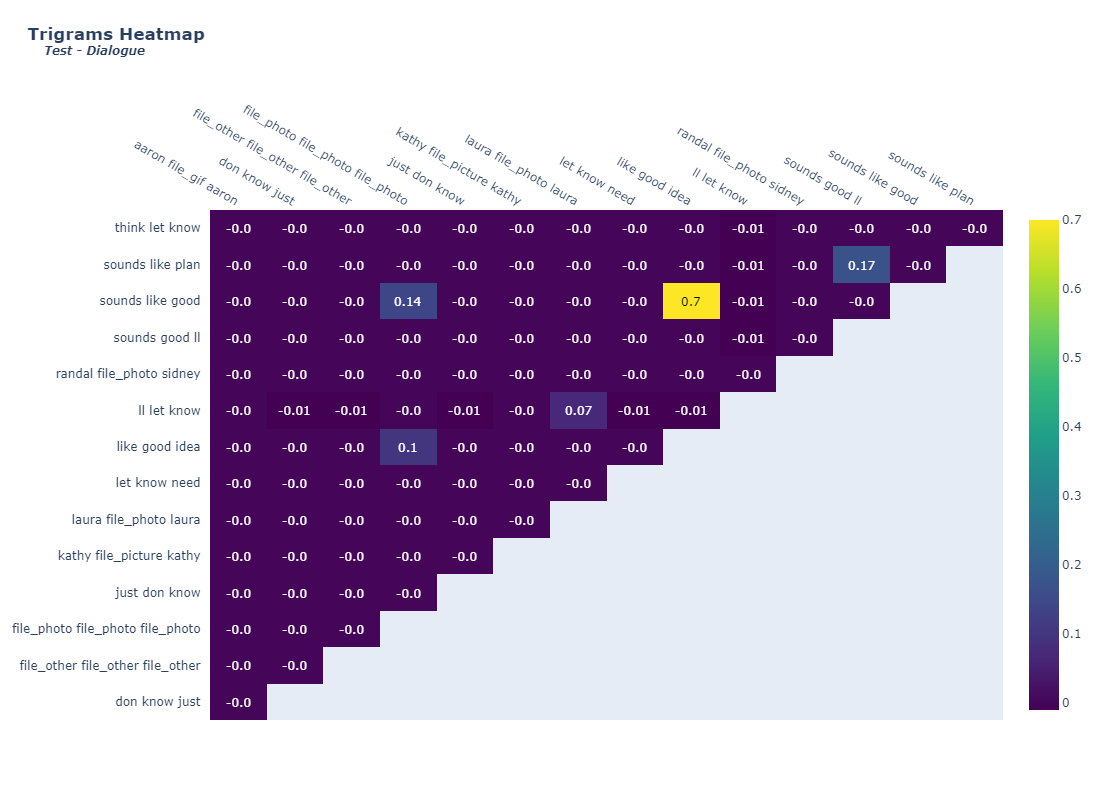

In [32]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (3,3)) # Top 15 terms
x = vectorizer.fit_transform(test_df['dialogue'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Trigrams', 'Test - Dialogue', 800, 800, 12)

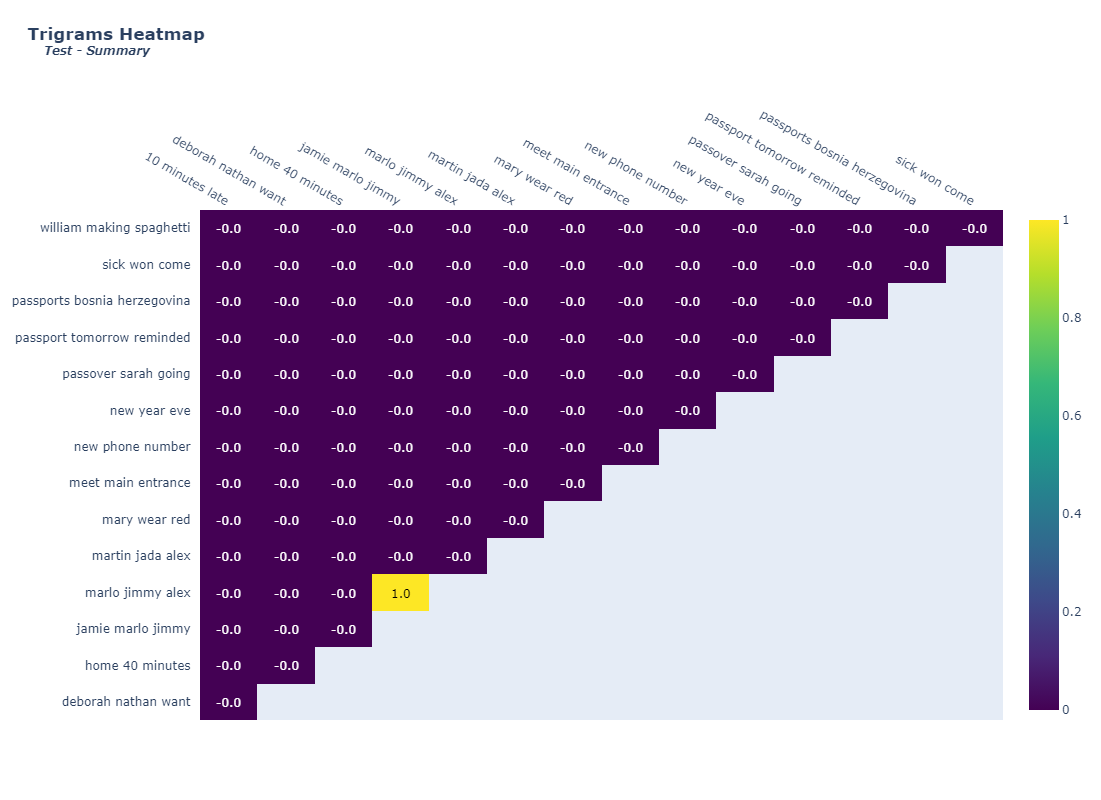

In [33]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (3,3)) # Top 15 terms
x = vectorizer.fit_transform(test_df['summary'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Trigrams', 'Test - Summary', 800, 800, 12)

#### Validation Datasets

In [34]:
describe_df(val_df)


DataFrame shape: (818, 3)
--------------------

818 samples
--------------------

3 attributes
--------------------

Missing Data: 
id          0
dialogue    0
summary     0
dtype: int64
--------------------

Duplicates: 0
--------------------

Data Types: 
id          object
dialogue    object
summary     object
dtype: object
--------------------

Categorical Features: 
id, dialogue, summary
--------------------

Continuous Features: 
None
--------------------

Binary Features: 
None
--------------------

DataFrame Head: 



id                                           dialogue  \
0  13817023  A: Hi Tom, are you busy tomorrow’s afternoon?\...   
1  13716628  Emma: I’ve just fallen in love with this adven...   
2  13829420  Jackie: Madison is pregnant\r\nJackie: but she...   
3  13819648  Marla: <file_photo>\r\nMarla: look what I foun...   
4  13728448  Robert: Hey give me the address of this music ...   

                                             summary  
0  A will go to the animal shelter tomorrow to ge...  
1  Emma and Rob love the advent calendar. Lauren ...  
2  Madison is pregnant but she doesn't want to ta...  
3        Marla found a pair of boxers under her bed.  
4  Robert wants Fred to send him the address of t...


DataFrame Tail: 



id                                           dialogue  \
813  13829423  Carla: I've got it...\r\nDiego: what?\r\nCarla...   
814  13727710  Gita: Hello, this is Beti's Mum Gita, I wanted...   
815  13829261  Julia: Greg just texted me\r\nRobert: ugh, del...   
816  13680226  Marry: I broke my nail ;(\r\nTina: oh, no!\r\n...   
817  13862383  Paige: I asked them to wait and send the decla...   

                                               summary  
813  Carla's date for graduation is on June 4th. Di...  
814  Bev is going on the school trip with her son. ...  
815  Greg cheated on Julia. He apologises to her. R...  
816  Marry broke her nail and has a party tomorrow....  
817  Paige wants to have the declaration sent later...

In [35]:
eda_val_df = create_eda_df(val_df)

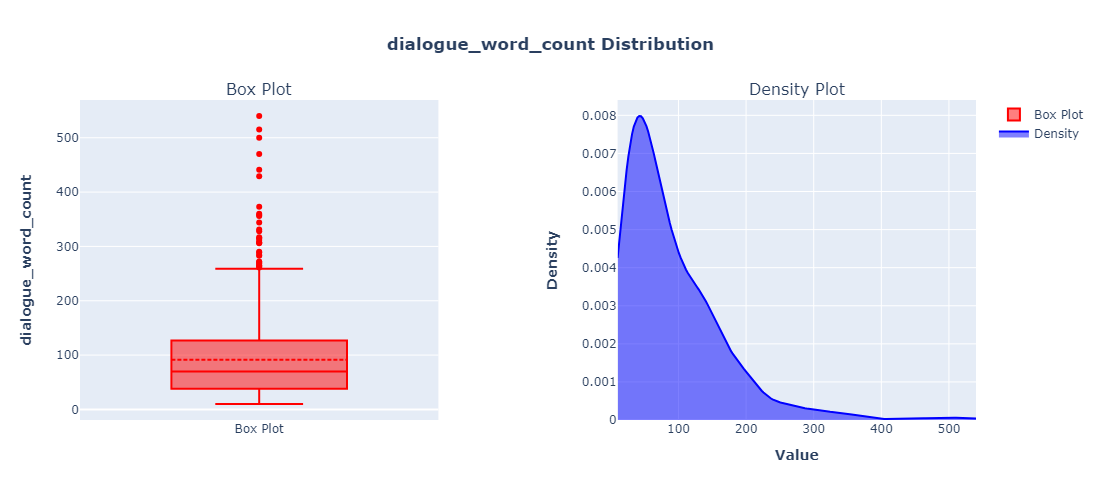

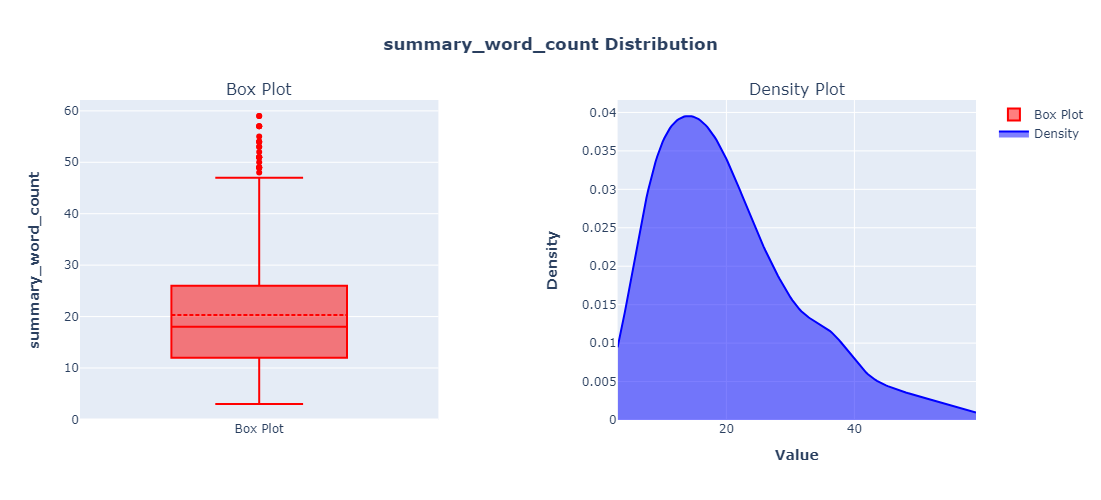

In [36]:
cols = eda_val_df.columns[4:]
for col in cols:
    visualize(eda_val_df, col)

From this boxplot-histogram visualization of test dataset, we observed that
- **Dialogue Word Count**
    - The average word count(mean) of the dialogue is around 92 words
    - There are several dialogue(outliers) above 259 words
    - From histogram plot(right side), show a right-skewed distribution. Most summaries are short, with a high frequency of around 42 words.
- **Summary Word Count**
    - The average word count(mean) of the summarize is around 20 words
    - There are several dialogue(outliers) above 47 words
    - From histogram plot(right side), show a right-skewed distribution. Most summaries are short, with a high frequency of around 14 words.

* #### Analyze Unigram,Bigram and trigram in Validation Dataset

- Unigram

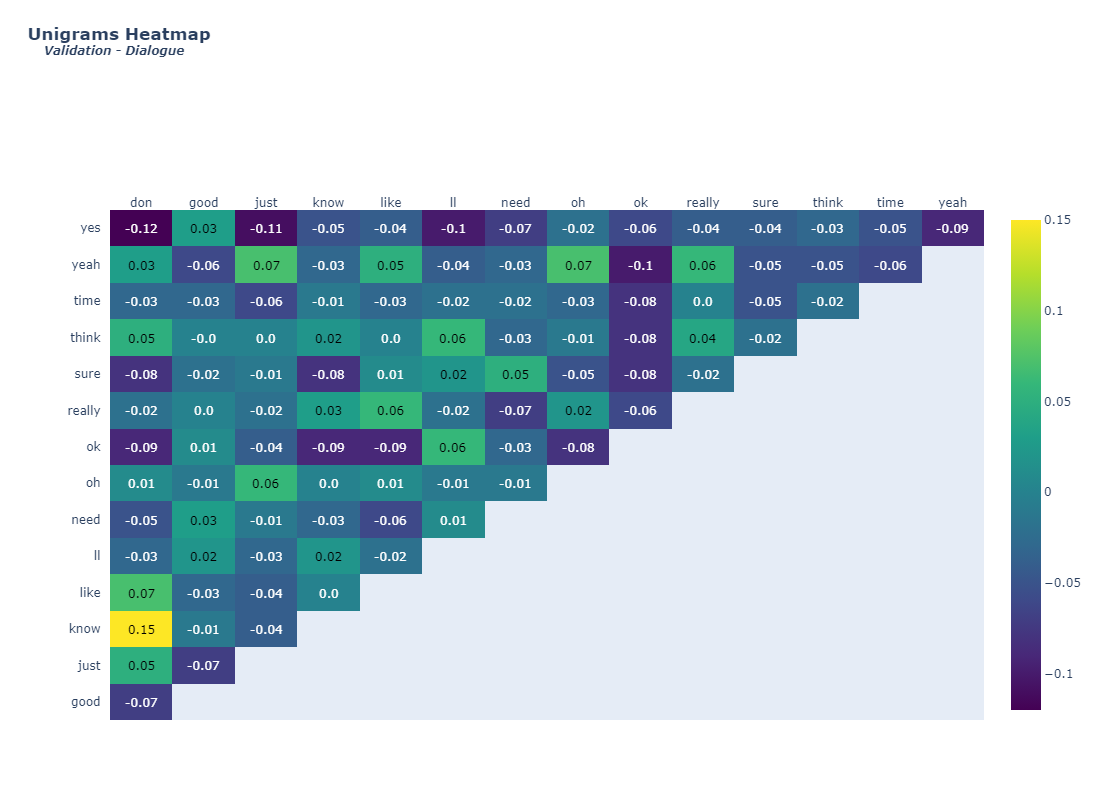

In [37]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english') # Top 15 terms
x = vectorizer.fit_transform(val_df['dialogue'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Unigrams', 'Validation - Dialogue', 800, 800, 12)

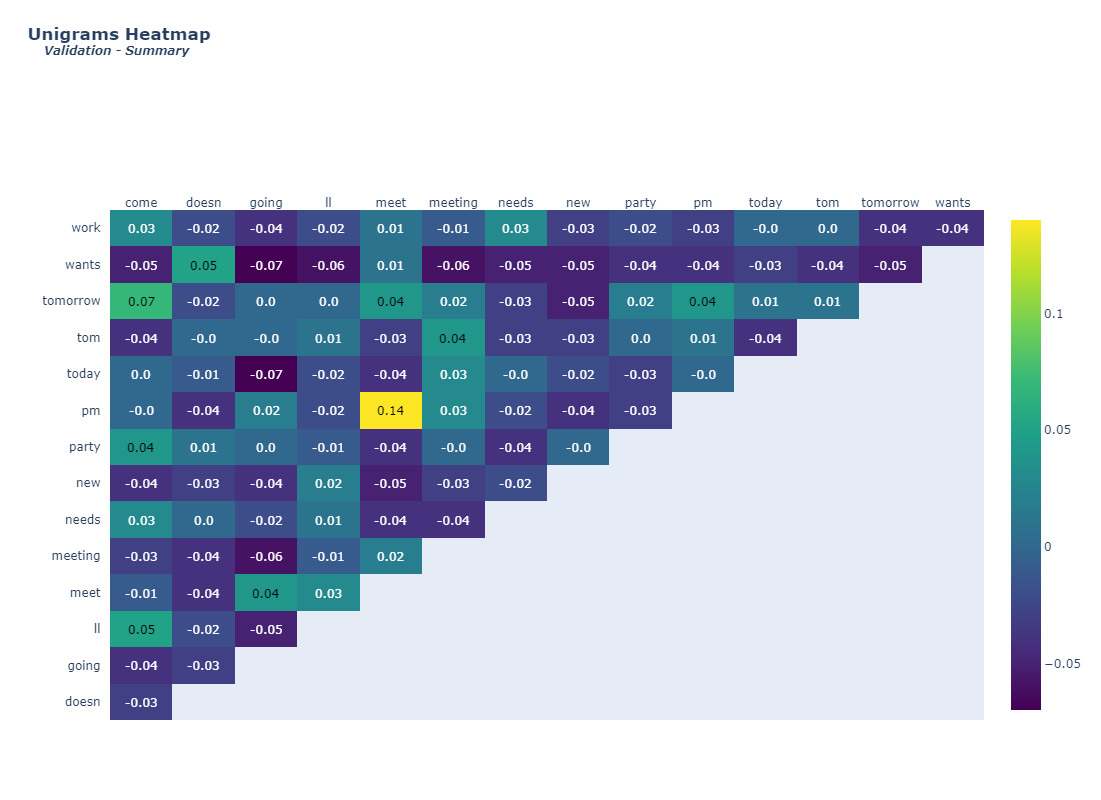

In [38]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english') # Top 15 terms
x = vectorizer.fit_transform(val_df['summary'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Unigrams', 'Validation - Summary', 800, 800, 12)

- Bigram

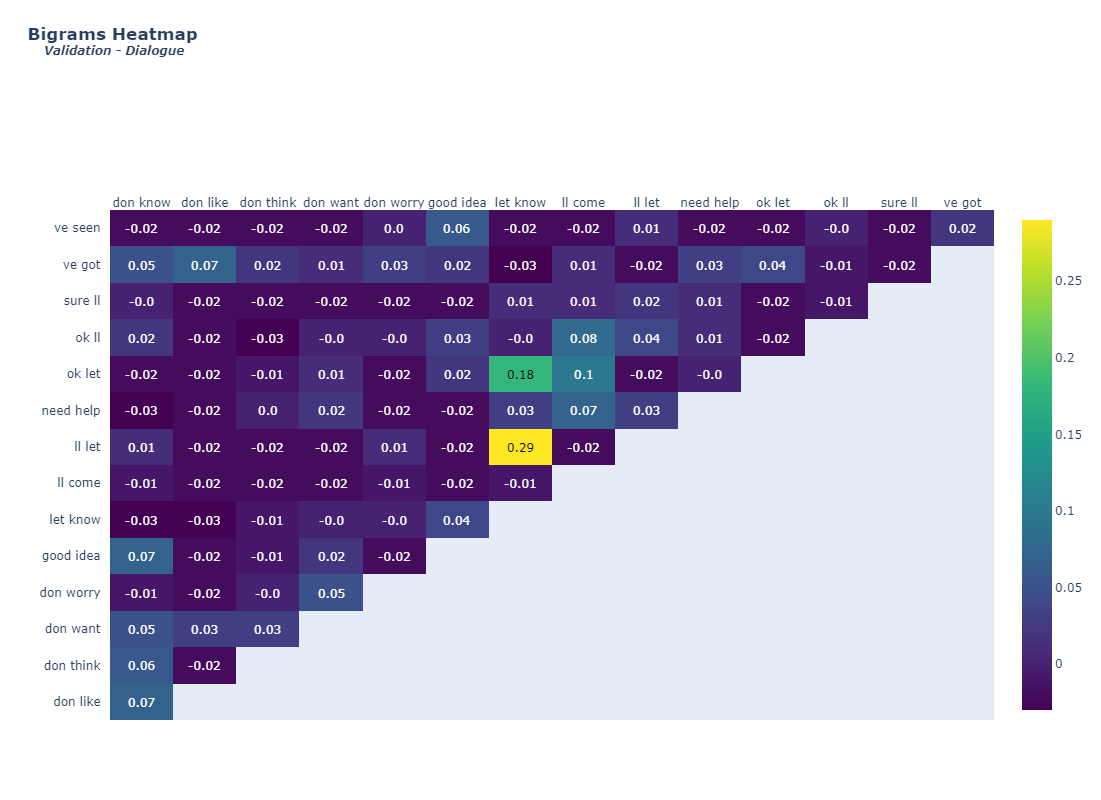

In [39]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (2,2)) # Top 15 terms
x = vectorizer.fit_transform(val_df['dialogue'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Bigrams', 'Validation - Dialogue', 800, 800, 12)

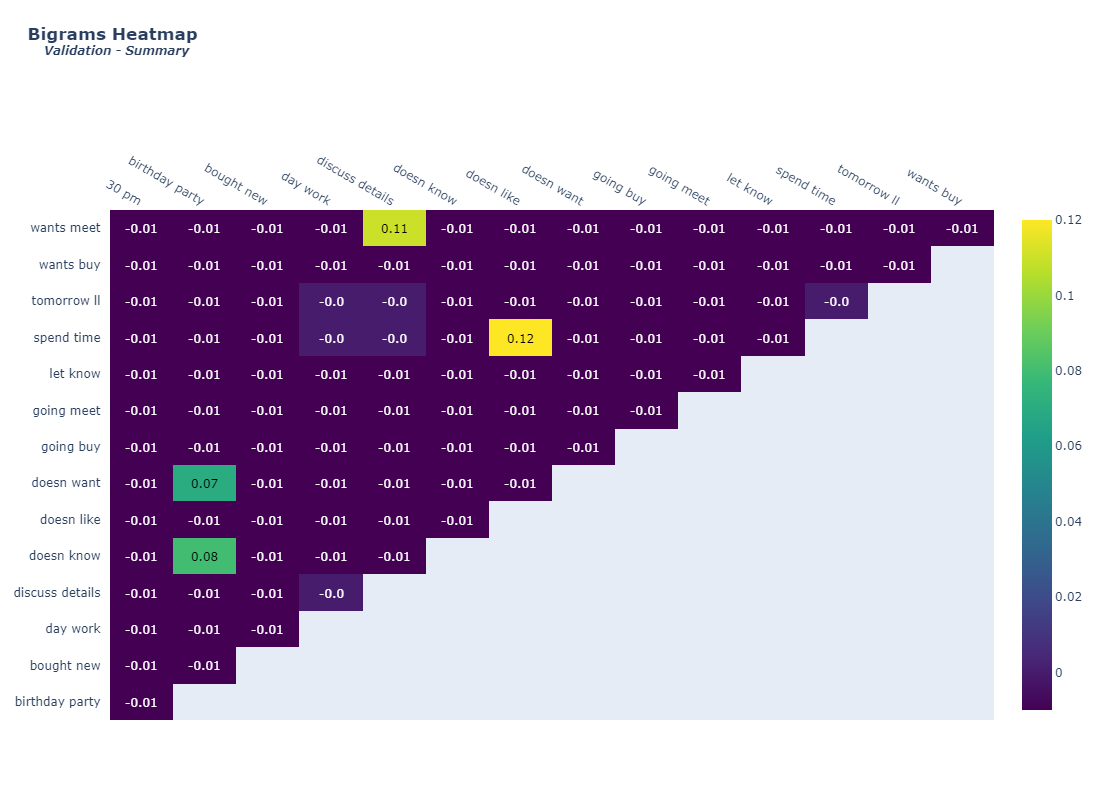

In [40]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (2,2)) # Top 15 terms
x = vectorizer.fit_transform(val_df['summary'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Bigrams', 'Validation - Summary', 800, 800, 12)

- Trigram

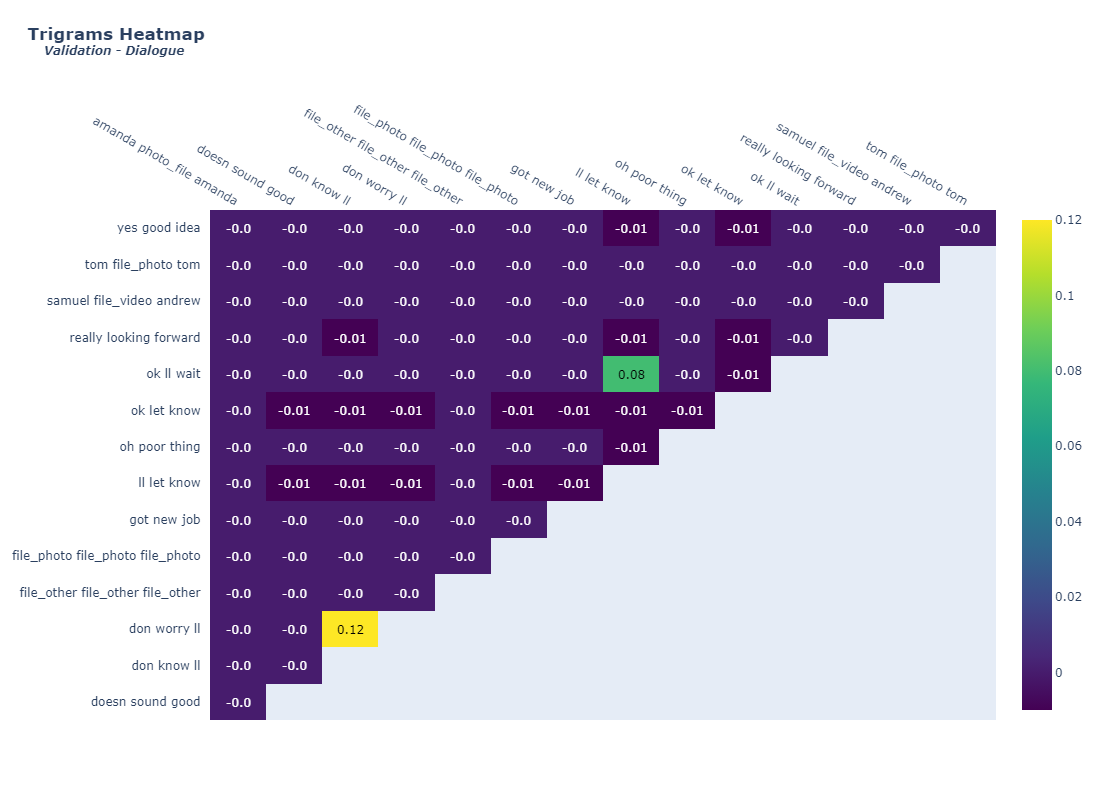

In [41]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (3,3)) # Top 15 terms
x = vectorizer.fit_transform(val_df['dialogue'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Trigrams', 'Validation - Dialogue', 800, 800, 12)

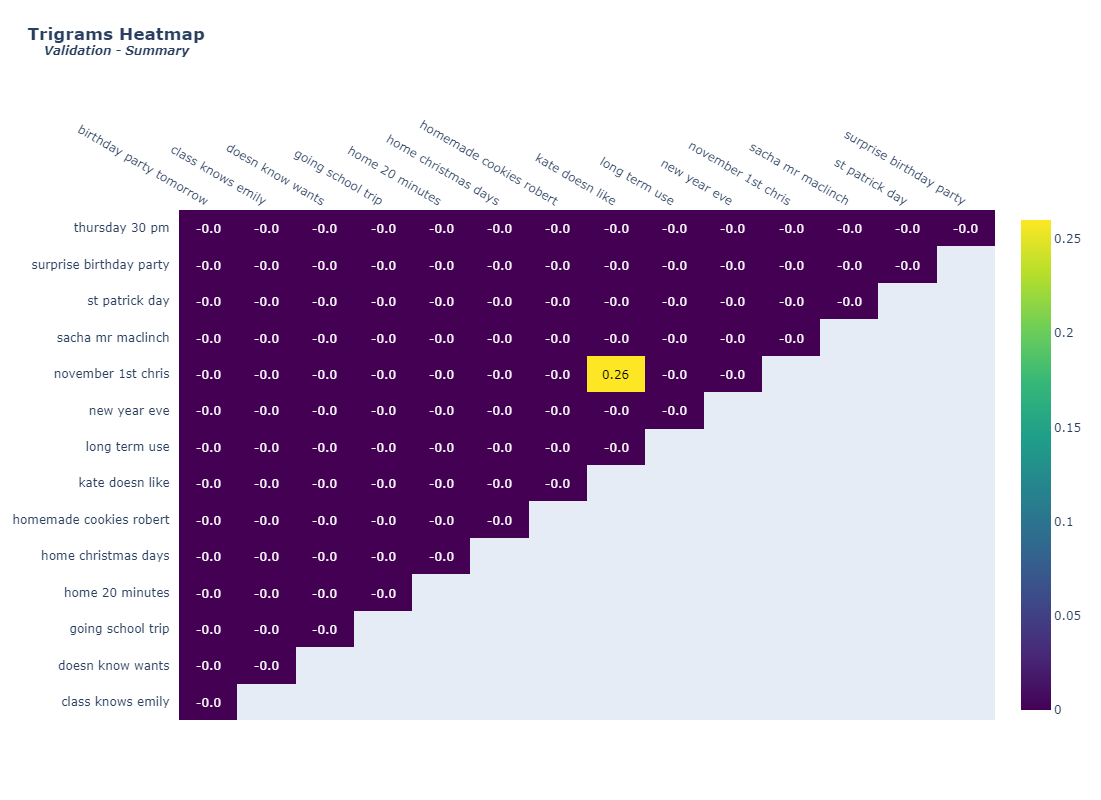

In [42]:
vectorizer = TfidfVectorizer(max_features = 15,stop_words = 'english',ngram_range = (3,3)) # Top 15 terms
x = vectorizer.fit_transform(val_df['summary'].fillna(''))
df_tfidfvect = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
plot_correlation(df_tfidfvect, 'Trigrams', 'Validation - Summary', 800, 800, 12)

Overall, those 3 datasets has similar patterns.
   - Summaries are shorter in length than dialogues.
   - Many terms seem reasonable to be together have a higher degree of correlation.

## Data Preprocessing

* #### Removing tags
After explore the datasets, we see there is tags in some line, which not quite meaningful to the text. so we need to remove it out

In [43]:
# remove the tags
def clean_tags(text):
    clean = re.compile('<.*?>') # Compiling tags
    clean = re.sub(clean, '', text) # Replacing tags text by an empty string

    # Removing empty dialogues
    clean = '\n'.join([line for line in clean.split('\n') if not re.match('.*:\s*$', line)])

    return clean

# Defining function to clean every text in the dataset.
def clean_df(df, cols):
    for col in cols:
        df[col] = df[col].fillna('').apply(clean_tags)
    return df

In [44]:
# Cleaning texts in all datasets
train_df = clean_df(train_df,['dialogue', 'summary'])
test_df = clean_df(test_df,['dialogue', 'summary'])
val_df = clean_df(val_df,['dialogue', 'summary'])

In [45]:
train_df.tail(3) # Visualizing results

id                                           dialogue  \
14729  13819050  John: Every day some bad news. Japan will hunt...   
14730  13828395  Jennifer: Dear Celia! How are you doing?\r\nJe...   
14731  13729017  Georgia: are you ready for hotel hunting? We n...   

                                                 summary  
14729  Japan is going to hunt whales again. Island an...  
14730  Celia couldn't make it to the afternoon with t...  
14731  Georgia and Juliette are looking for a hotel i...

* #### Transforming dataframes into Huggingface datasets
We use the Huggingface's model for training, so we need to transform the dataframe into Huggingface datasets

In [46]:
# Transforming dataframes into datasets
train_ds = Dataset.from_pandas(train_df, preserve_index=False) # reset the index after cleaning
test_ds = Dataset.from_pandas(test_df)
val_ds = Dataset.from_pandas(val_df)

dataset_dict = {
    "train": train_ds,
    "test": test_ds,
    "validation": val_ds
}

data = DatasetDict(dataset_dict)

In [47]:
data

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14731
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

## Text Preprocessing

In this step we will use **tokenization** to facilitate language processing tasks by providing a structured representation of textual data.
- The model for sequence-to-sequence task is T5 model.
- To perform tokenization(text processing), we load a pre-trained tokenizer for the T5 model.

In [48]:
model_name = "t5-small" # Seq2Seq model

In [50]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [51]:
# test the tokenizer
tokenizer("Hi, my name is Thomas")

{'input_ids': [2018, 6, 82, 564, 19, 3576, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [52]:
# These values were chosen based on the initial analysis (at box-histogram plot)
max_dialogue_length = 1408
max_summary_length = 265

# function for tokenize the datasets
def preprocess_function(samples):
    inputs = ["summarize: " + doc for doc in samples["dialogue"]]
    model_inputs = tokenizer(inputs, max_length=max_dialogue_length, truncation=True)
    
    labels = tokenizer(text_target=samples["summary"], max_length=max_summary_length, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    
    return model_inputs

In [53]:
data['train'][0]

{'id': '13818513',
 'dialogue': "Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)",
 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.'}

In [54]:
# test the sameple text
preprocess_function(data["train"][0])

{'input_ids': [[21603, 10, 71, 1], [21603, 10, 3, 51, 1], [21603, 10, 3, 9, 1], [21603, 10, 3, 29, 1], [21603, 10, 3, 26, 1], [21603, 10, 3, 9, 1], [21603, 10, 3, 10, 1], [21603, 10, 1], [21603, 10, 27, 1], [21603, 10, 1], [21603, 10, 3, 115, 1], [21603, 10, 3, 9, 1], [21603, 10, 3, 157, 1], [21603, 10, 3, 15, 1], [21603, 10, 3, 26, 1], [21603, 10, 1], [21603, 10, 1], [21603, 10, 3, 75, 1], [21603, 10, 3, 32, 1], [21603, 10, 3, 32, 1], [21603, 10, 3, 157, 1], [21603, 10, 3, 23, 1], [21603, 10, 3, 15, 1], [21603, 10, 3, 7, 1], [21603, 10, 3, 5, 1], [21603, 10, 1], [21603, 10, 309, 1], [21603, 10, 3, 32, 1], [21603, 10, 1], [21603, 10, 3, 63, 1], [21603, 10, 3, 32, 1], [21603, 10, 3, 76, 1], [21603, 10, 1], [21603, 10, 3, 210, 1], [21603, 10, 3, 9, 1], [21603, 10, 3, 29, 1], [21603, 10, 3, 17, 1], [21603, 10, 1], [21603, 10, 3, 7, 1], [21603, 10, 3, 32, 1], [21603, 10, 3, 51, 1], [21603, 10, 3, 15, 1], [21603, 10, 3, 58, 1], [21603, 10, 1], [21603, 10, 1], [21603, 10, 446, 1], [21603, 10

In [55]:
# tokenize train, test, validation datasets
tokenized_data = data.map(preprocess_function, batched=True, remove_columns=['id', 'dialogue', 'summary'])

Map:   0%|          | 0/14731 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [56]:
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 14731
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
})

## Model Training

In [58]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

In [60]:
batch_size = 16 # model will look at 16 samples from the training dataset and perform a forward pass to calculate the loss
epochs = 32
checkpoint_path = "./t5-small/checkpoint-18000"

model_label_name = f"{model_name}-transcript-summarizer"
args = Seq2SeqTrainingArguments(
    model_name,                                                        # Specify Model name
    evaluation_strategy="epoch",                                       # Evaluate performance at Epoch end
    learning_rate=2e-5,                            
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01, 
    save_total_limit=3,                                                # Save the model only 3 times
    num_train_epochs=epochs,                                           # Number of Epochs
    predict_with_generate=True,                                        # To predict Sequences
    fp16=True,                                                         # Set to fp16, mixed precision training
    push_to_hub=False,                                                  # Push model to huggingface
    # resume_from_checkpoint=checkpoint_path  # Specify the checkpoint to resume from
)

Data Collator is a function that helps convert a dataset from a list format into batch tensors, which facilitates the preprocessing of input data to be fed into deep learning models.

In [61]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

* We will use compute_metrics function for compute the evaluation scores and we will use ROUGE scores to evaluate the quality of the generated text and this function will also calculates the average length of the generated text.

In [62]:
metric = load("rouge")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id) 
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    result = {key : value for key, value in result.items()}
    
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    
    return {k: round(v,4) for k,v in result.items()}

In [61]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [62]:
trainer.train()

wandb: Currently logged in as: thomas1112 (chang_organization). Use `wandb login --relogin` to force relogin


TrainOutput(global_step=29472, training_loss=1.7792645308404482, metrics={'train_runtime': 9650.71, 'train_samples_per_second': 48.845, 'train_steps_per_second': 3.054, 'total_flos': 4.980425796737434e+16, 'train_loss': 1.7792645308404482, 'epoch': 32.0})

**Performance Dashboard** : https://wandb.ai/chang_organization/huggingface?nw=nwuserthomas1112 

In [ ]:
# save model and tokenizer (these model I trained in kaggle notebook)
model_save_path = "/kaggle/working/model_save"
tokenizer_save_path = "/kaggle/working/tokenizer_save"

trainer.save_model(model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

### Description
- Epoch:The number of training epochs completed.
- Training Loss:The loss value computed on the training dataset at the end of each epoch. **Lower values indicate that the model is learning and fitting the training data better over time**.
- Validation Loss:The loss value computed on the validation dataset at the end of each epoch. **Lower values indicate better performance on the validation set**.
- Rouge1:measures the overlap of **unigrams** (single words) between the predicted and reference summaries. **Higher values indicate better performance**.
- Rouge2: measures the overlap of **bigrams** (pairs of consecutive words) between the predicted and reference summaries. **Higher values indicate better performance**.
- RougeL: measures the **longest common subsequence (LCS)** between the predicted and reference summaries. This score considers **sentence-level structure similarity**. Higher values indicate better performance.
- RougeLsum: The ROUGE-Lsum score, a variant of ROUGE-L applied to the summary-level evaluation. It measures the LCS of the entire summary rather than individual sentences. Higher values indicate better performance.
- Gen Len: The average length of the generated summaries. This provides an insight into how concise the model's outputs are.

## Testing Fine-Tuned Model

In [ ]:
results = trainer.evaluate(tokenized_data["test"])

In [ ]:
for k,v in results.items():
    print(f"{k:{30}}{round(v,3):{20}}")

### Push tokenizer and model to huggingface

In [64]:
repo = "gaoweic/Model"

In [ ]:
model.push_to_hub(repo)
tokenizer.push_to_hub(repo)

* #### Build model pipeline
    For simplifies the use of pre-trained models for summarization

In [65]:
# Load the saved model and tokenizer from HuggingFace
saved_model = AutoModelForSeq2SeqLM.from_pretrained(repo)
saved_tokenizer = AutoTokenizer.from_pretrained(repo)

In [66]:
# Create the summarization pipeline
summarizer = pipeline('summarization', model=saved_model, tokenizer=saved_tokenizer)

* #### Test the pipeline

In [67]:
dialogue = data["test"][0]["dialogue"]
dialogue

"Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him 🙂\nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye"

In [68]:
summary = data["test"][0]["summary"]
summary

"Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry."

In [75]:
# display first random 3 text summary from test dataset 
for _ in range(3):    
    idx = random.randint(0, 818)

    dialogue = data["test"][idx]["dialogue"]
    summary = data["test"][idx]["summary"]

    predicted = summarizer(dialogue, min_length=15, max_length=23, do_sample=False)
    
    print("="*100)
    print(f"Dialogue:\n{dialogue}")
    print("-"*50)
    print(f"Summary:\n{summary}")
    print("-"*50)
    print(f"Model Summary (Predicted):\n{predicted[0]['summary_text']}")

Dialogue:
Oliver: Dude, how's the campaign going?
Bruce: It's more than ok, we've got around 200 backers right now
Oliver: Good! Have we reached 5000 dollars yet?
Bruce: Yes, we're a little over 6000... 6132 bucks.
Oliver: Crowdfunding is the way!
--------------------------------------------------
Summary:
Bruce informs Oliver that the campaign is more than successful. They have so far won about 200 backers and crowdfunded 6123 dollars.
--------------------------------------------------
Model Summary (Predicted):
The campaign is more than ok. They've got around 200 backers right now. They have reached
Dialogue:
Claire: hey 
Claire: where's this conference about relations at school?
Aaron: hey
Aaron: it's in the teaching training thing
Claire: oh, in Sesame Street?
Aaron: yeah exactly
Claire: thanks! 
Claire: are you going? i mean apart from your own lecture ;D
Aaron: haha yeah i'm giving two, actually
Aaron: and i'm kind of a host there as well 
Aaron: so guess i'll be looking to coffe

In [70]:
# business chat
# Example business chat text to summarize
business_chat = """
Alice: Good morning, John. I wanted to discuss the progress on the new marketing campaign.

John: Good morning, Alice. Sure, I'd be happy to provide an update. We've completed the initial market research and identified our target demographics.

Alice: That's great to hear. Have we started creating the ad content yet?

John: Yes, the content creation team has started working on the ad scripts and visuals. We plan to have the first drafts ready by the end of this week.

Alice: Excellent. What about the budget? Are we still within the allocated amount?

John: So far, yes. We've spent around 60% of the budget, and we have enough left to cover the remaining phases of the campaign.

Alice: Perfect. I also wanted to discuss our strategy for social media. Have we decided on which platforms to focus on?

John: We have. We're focusing primarily on Instagram and LinkedIn, as our research shows that these platforms have the highest engagement rates for our target audience.

Alice: Good choice. Let's make sure we tailor our content to fit each platform's unique style and audience.

John: Absolutely. The team is already working on platform-specific content strategies.

Alice: Great. Let's aim to review the first drafts together on Friday. Does that work for you?

John: Yes, that works for me. I'll schedule a meeting for Friday afternoon.

Alice: Thanks, John. I appreciate the update. Let's keep the momentum going.

John: Will do, Alice. Have a great day!

Alice: You too, John.
"""

# Generate summary with adjusted max_length
chat_summary = summarizer(business_chat, max_length=80, min_length=25, do_sample=False)

In [71]:
chat_summary[0]['summary_text']

'John and Alice will discuss the progress on the new marketing campaign. They will review the first drafts together on Friday afternoon.'

In [72]:
# Lets try news article

news_article = """
In a groundbreaking development for the renewable energy sector, researchers at the National Institute of Advanced Technology have unveiled a new solar panel technology that promises to revolutionize the industry. This innovative technology increases the efficiency of solar panels by 50%, making solar energy more viable and cost-effective than ever before.

The team of scientists, led by Dr. Elena Rodriguez, has been working on this project for the past five years. The new technology utilizes a novel material known as perovskite, which is capable of capturing a broader spectrum of sunlight compared to traditional silicon-based panels. Perovskite solar cells have shown tremendous potential in laboratory settings, and this latest advancement brings them one step closer to widespread commercial use.

“Our new perovskite solar cells are not only more efficient but also cheaper to produce,” said Dr. Rodriguez. “This breakthrough could significantly reduce the cost of solar energy and accelerate the transition to a sustainable energy future.”

The implications of this technology are vast. With higher efficiency and lower production costs, solar power could become a more competitive alternative to fossil fuels, reducing greenhouse gas emissions and combating climate change. Additionally, the increased efficiency means that less space is required for solar farms, making it easier to integrate solar power into urban environments.

The research team has already partnered with several major solar panel manufacturers to begin the process of commercializing the technology. Field tests are scheduled to start later this year, with plans for large-scale production within the next two years.

Industry experts have hailed this development as a major milestone in the quest for sustainable energy. “This is a game-changer for the solar industry,” said James Caldwell, CEO of Solar Future Inc. “The increased efficiency and reduced costs will make solar power accessible to more people and help drive the global shift towards renewable energy.”

As the world grapples with the challenges of climate change and the need for cleaner energy sources, innovations like this offer a beacon of hope. The National Institute of Advanced Technology’s breakthrough could mark the beginning of a new era in renewable energy, bringing us closer to a future powered by clean, sustainable energy.
"""

news_summary = summarizer(news_article, max_length=80, min_length=25, do_sample=False)

In [73]:
news_summary[0]['summary_text']

'National Institute of Advanced Technology has unveiled a new solar panel technology that promises to revolutionize the industry. The new technology uses a novel material known as Perovskite, which is capable of capturing a broader spectrum of sunlight compared to traditional silicon-based panels.'